In [1]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from eeg_recording import SingleSubjectRecording
from sklearn.decomposition import (
    NMF,
    PCA,
    FactorAnalysis,
    FastICA,
    LatentDirichletAllocation,
)
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)

plt.style.use("default_light")
plt.rcParams["figure.figsize"] = (15, 10)

In [2]:
mne_data = mne.io.read_raw_eeglab(
    "../../data/test_data_LEMON/sub-010002_EC.set", preload=True
)
eeg = SingleSubjectRecording(subject_id="01", data=mne_data.crop(tmax=10.0))
# preprocess
eeg.preprocess(2.0, 20.0)
eeg.gfp()
data_arr = eeg.data
data_arr.shape

Reading /Users/nikola/work-brain/eeg_microstate_and_latent_space/notebooks/paper/../../data/test_data_LEMON/sub-010002_EC.fdt
Reading 0 ... 119344  =      0.000 ...   477.376 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 413 samples (1.652 sec)



/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_94504/3220015972.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  "../../data/test_data_LEMON/sub-010002_EC.set", preload=True
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_94504/3220015972.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  "../../data/test_data_LEMON/sub-010002_EC.set", preload=True


(59, 2501)

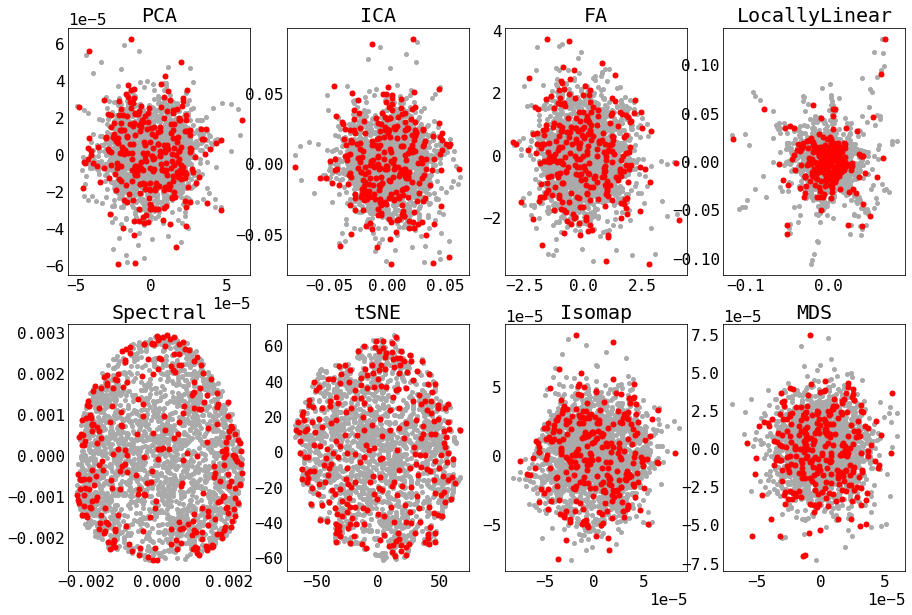

In [3]:
decomps = {
    "PCA": PCA(n_components=2),
    "ICA": FastICA(n_components=2),
    "FA": FactorAnalysis(n_components=2),
    "LocallyLinear": LocallyLinearEmbedding(n_components=2),
    "Spectral": SpectralEmbedding(n_components=2),
    "tSNE": TSNE(n_components=2),
    "Isomap": Isomap(n_components=2),
    "MDS": MDS(n_components=2),
}

plt.figure(figsize=(15, 10))
for i, (name, decomp) in enumerate(decomps.items()):
    comps = decomp.fit_transform(data_arr.T)
    plt.subplot(2, 4, i + 1)
    plt.plot(comps[:, 0], comps[:, 1], "o", color="#AAAAAA", markersize=4)
    plt.plot(
        comps[eeg.gfp_peaks, 0], comps[eeg.gfp_peaks, 1], "o", color="red", markersize=5
    )
    plt.title(name)

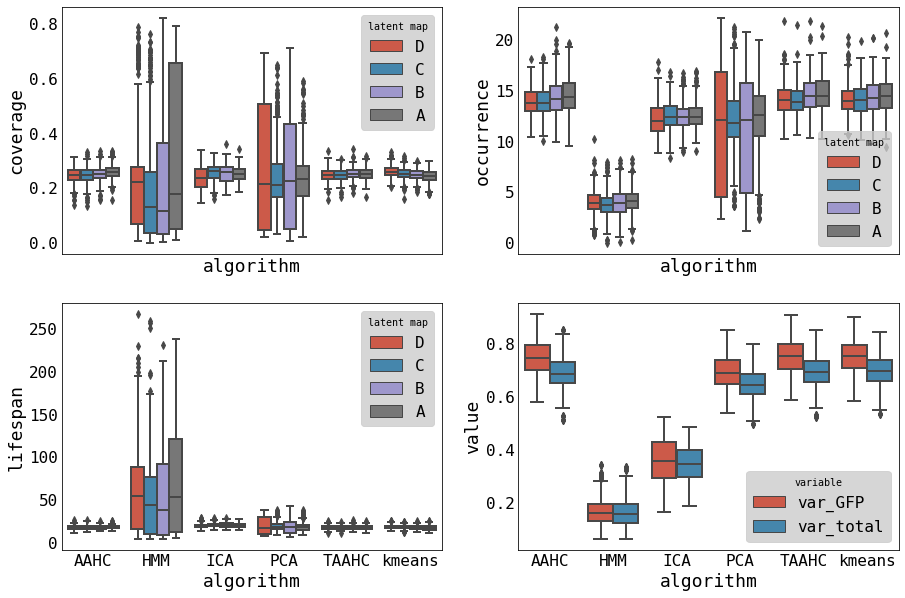

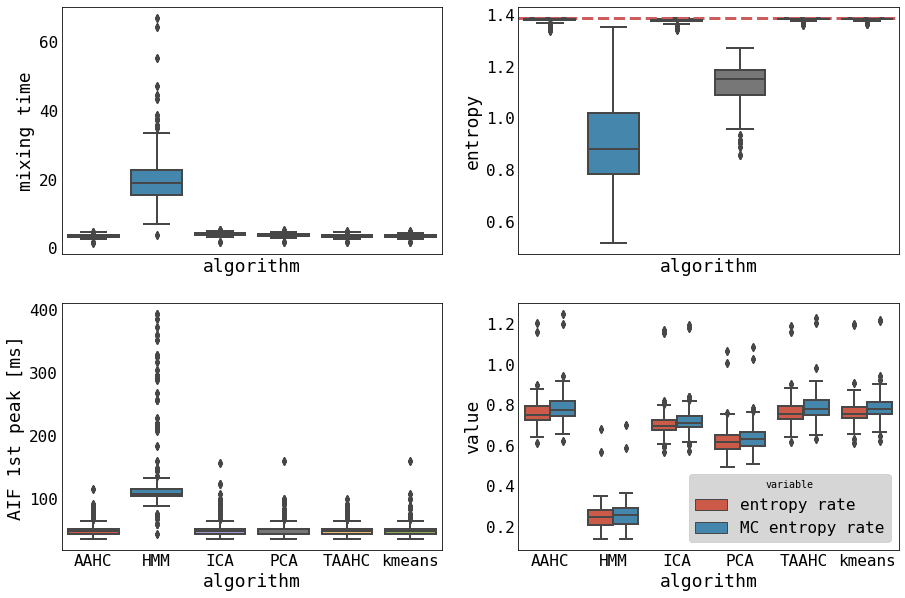

In [18]:
FOLDER = "../../results/aggregated-new/"

stats = pd.read_csv(os.path.join(FOLDER, "stats.csv"))
stats = stats[(stats["surrogate_type"] == "real_data") & (stats["data_type"] == "EC")]
stats = stats.rename(columns={"decomposition_type": "algorithm"}).replace({"hmm": "HMM"})
stats = stats.sort_values(by="algorithm")

_, axs = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(15, 10))
sns.boxplot(data=stats, x="algorithm", y="coverage", hue="latent map", ax=axs[0, 0])
sns.boxplot(data=stats, x="algorithm", y="occurrence", hue="latent map", ax=axs[0, 1])
sns.boxplot(data=stats, x="algorithm", y="lifespan", hue="latent map", ax=axs[1, 0])
sns.boxplot(
    data=stats.melt(id_vars=["algorithm"], value_vars=["var_GFP", "var_total"]),
    x="algorithm",
    y="value",
    hue="variable",
    ax=axs[1, 1],
)
plt.show()


_, axs = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(15, 10))
sns.boxplot(data=stats, x="algorithm", y="mixing time", ax=axs[0, 0])
sns.boxplot(data=stats, x="algorithm", y="entropy", ax=axs[0, 1])
axs[0, 1].axhline(
    stats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
sns.boxplot(data=stats, x="algorithm", y="AIF 1st peak [ms]", ax=axs[1, 0])
sns.boxplot(
    data=stats.melt(
        id_vars=["algorithm"], value_vars=["entropy rate", "MC entropy rate"]
    ),
    x="algorithm",
    y="value",
    hue="variable",
    ax=axs[1, 1],
)
plt.show()

In [13]:

subj_topo = (
    xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))
    .squeeze()
    .sel({"data_type": "EC"})
)
# subj_topo = subj_topo.stack(all=("data_type", "surrogate_type", "subject_id"))

In [14]:
subj_topo

<xarray.DataArray (decomposition_type: 6, subject_id: 203, latent map: 4, channels: 61)>
[297192 values with dtype=float64]
Coordinates:
  * subject_id          (subject_id) object 'sub-010002' ... 'sub-010321'
  * decomposition_type  (decomposition_type) object 'AAHC' 'ICA' ... 'kmeans'
  * latent map          (latent map) object 'A' 'B' 'C' 'D'
  * channels            (channels) int64 0 1 2 3 4 5 6 ... 54 55 56 57 58 59 60
    no_states           int64 ...
    surrogate_type      <U9 'real_data'
    data_type           <U2 'EC'

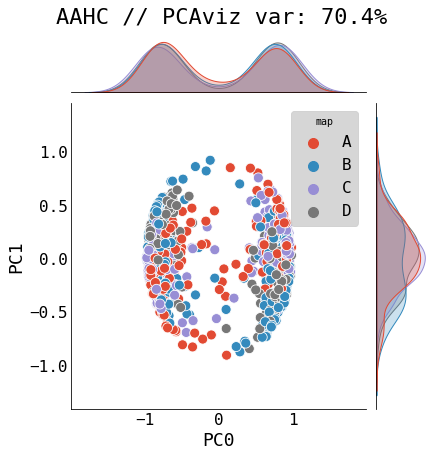

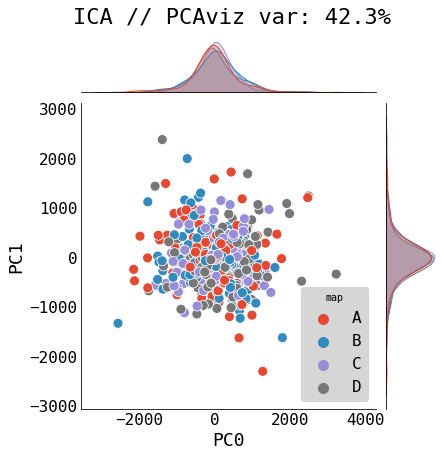

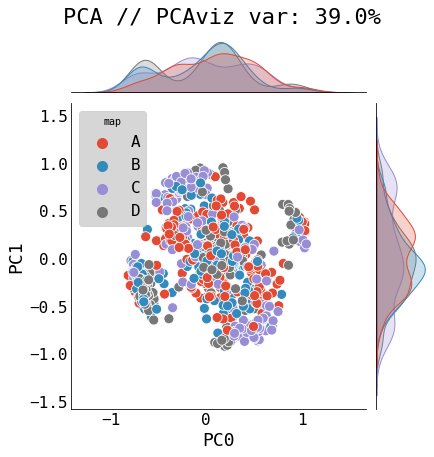

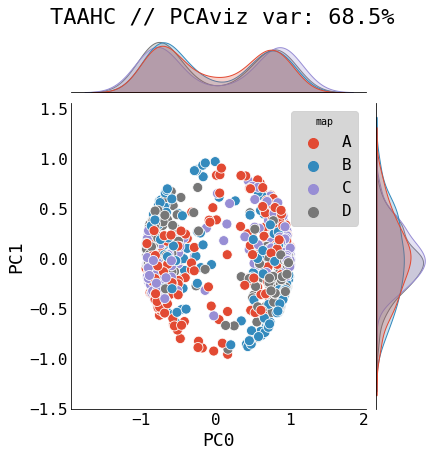

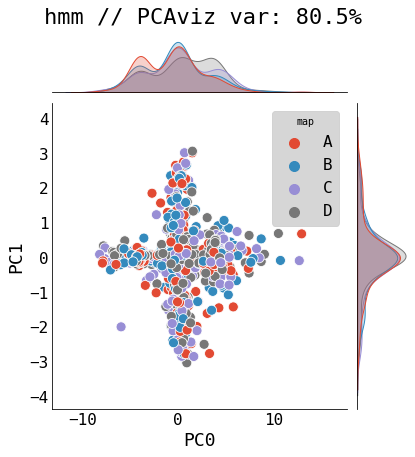

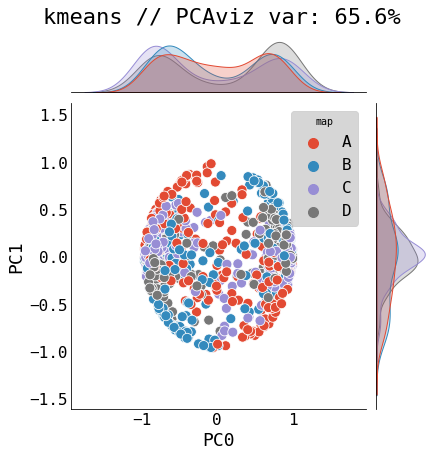

In [46]:
for decomp in subj_topo["decomposition_type"]:
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(subj_topo.stack(samples=("subject_id", "latent map")).sel({"decomposition_type": decomp}).values.T)
    low_dim = pd.DataFrame(pcs, columns=["PC0", "PC1"])
    low_dim["map"] = subj_topo.stack(samples=("subject_id", "latent map")).sel({"decomposition_type": decomp})["latent map"]
    g = sns.jointplot(data=low_dim, x="PC0", y="PC1", hue="map")
    g.fig.suptitle(f"{decomp.values} // PCAviz var: {pca.explained_variance_ratio_.sum():.1%}", y=1.05)
    plt.show()